# Pharmacodynamic Model of Tumor Growth

An example of how to use modelbase v.1.2.3.

Replication of the pharmacodynamic model of Tumor Growth after administration of anticancer agents published by Simeoni et al, CANCER RESEARCH 64, 1094 –1101, February 1, 2004

In [1]:
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from modelbase.ode import Model, Simulator
from modelbase.ode import ratelaws as rl

variables = ["x1", "x2", "x3", "x4"]

p = {
    "l0": 0.0154,
    "l1": 0.0211,
    "k1": 0.0265,
    "w0": 0.0162,
    "k2": 0.000,
    "psi": 1.0,
    "c": 1.0,  #  concentration of a therapeutic. Should be a pharmacokinetic function dependent on time
}

w0 = 0.0162
y0 = {"x1": 0.0162, "x2": 0.0, "x3": 0.0, "x4": 0.0}

m = Model(parameters=p, compounds=variables)

In [2]:
def wmoiety(x1, x2, x3, x4):
    """ tumor growth """
    return x1 + x2 + x3 + x4


m.add_algebraic_module(
    module_name="w_alm",
    function=wmoiety,
    compounds=["x1", "x2", "x3", "x4"],
    derived_compounds=["w"],
)


def v1(x1, w, l0, l1, psi):
    """ growth function """
    v = l0 * x1 / (1 + (l0 / l1 * w) ** psi) ** (1 / psi)
    return v


m.add_reaction(
    rate_name="v1",
    function=v1,
    stoichiometry={"x1": 1},
    dynamic_variables=["x1", "w"],
    parameters=["l0", "l1", "psi"],
    reversible=False,
)


def v2(x1, k2, c):
    return k2 * c * x1


m.add_reaction(
    rate_name="v2",
    function=v2,
    stoichiometry={"x1": -1, "x2": 1},
    parameters=["k2", "c"],
    reversible=False,
)

m.add_reaction_from_ratelaw(
    rate_name="v3",
    ratelaw=rl.MassAction(substrates=["x2"], products=["x3"], k_fwd="k1"),
)
m.add_reaction_from_ratelaw(
    rate_name="v4",
    ratelaw=rl.MassAction(substrates=["x3"], products=["x4"], k_fwd="k1"),
)
m.add_reaction_from_ratelaw(
    rate_name="v5", ratelaw=rl.MassAction(substrates=["x4"], products=[], k_fwd="k1")
)

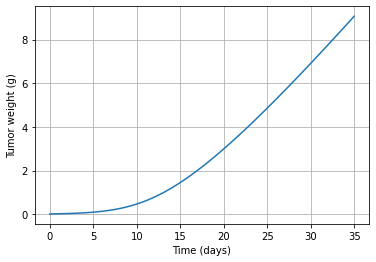

In [3]:
# tumor growth

s = Simulator(m)
s.initialise(y0)
s.simulate(35 * 24)
plt.plot(s.get_time() / 24, s.get_variable("w"))
plt.xlabel("Time (days)")
plt.ylabel("Tumor weight (g)")
plt.grid()
plt.show()

# Reproduce Figure 3
Effect of k2 on simulated tumor growth curves.

**Comment:** Single drug administration on day 9. Since the actual pharmacokinetic model was not provided in the paper, there was no point of implementing time dependent fancy function c(t) and I have instead defined c as a parameter set to 0 for the whole simulation, except day =9.

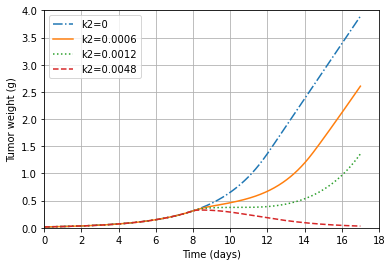

In [4]:
for k2, ls in zip([0, 6e-4, 12e-4, 48e-4], ["-.", "-", ":", "--"]):
    s.initialise(y0)
    s.update_parameters({"c": 0.0, "psi": 20.0, "k2": k2})
    s.simulate(8 * 24, steps=8 * 24)
    s.update_parameter("c", 65)
    s.simulate(9 * 24)
    s.update_parameter("c", 0.0)
    s.simulate(17 * 24, steps=10 * 24)    
    plt.plot(s.get_time() / 24, s.get_variable("w"), label=f"k2={k2}", linestyle=ls)
plt.xlabel("Time (days)")
plt.xlim(0, 18)
plt.ylim(0, 4)
plt.ylabel("Tumor weight (g)")
plt.legend()
plt.grid()
plt.savefig("tumorweight.png")
plt.show()